In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from scipy.stats import binom

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42
mono_color = "orchid"
poly_color = "green"

In [189]:
save_plots = True
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
maf_dir = ""

# SPECIFY LOCATION OF MAF FILES FOR THE TWO EXTERNAL COHORTS (NOT PROVIDED)
# This notebook computes ppVAFs for each mutation in these mafs using the scATAC data from our cohort
# Those steps will take some time to run and will require a nontrivial amount of memory (64 GB is sufficient)
Li_FAP_WES_loc = maf_dir+"PKU/PKU_samples.consensus.filtered.mpileups_filtered.ccfs.ccfs_noprobs.maf"
PKU_maf = pd.read_csv(Li_FAP_WES_loc, sep="\t")

Cross_sporadic_WES_loc = maf_dir+"BCI/Sporadic.consensus.filtered.mpileups_filtered.ccfs.ccfs_noprobs.maf"
BCI_maf = pd.read_csv(Cross_sporadic_WES_loc, sep="\t")

In [4]:
annot_dir = "../../data/scATACseq_annotations/"
purity_dict = pickle.load(open(annot_dir+"scATAC_purities.p", "rb"))

In [218]:
purity_table = pd.read_csv(annot_dir+"scATAC_celltype_fracs.csv")
purity_table

,Unnamed: 0,immune,stromal,epithelial,DiseaseState
0,A014-C-013,0.063634,0.014631,0.921736,Polyp
1,A002-C-021,0.110592,0.036345,0.853063,Polyp
2,A001-C-207,0.195334,0.023527,0.781139,Polyp
3,B004-A-004,0.244526,0.347546,0.407928,Normal
4,F072B,0.123219,0.015657,0.861124,Polyp
...,...,...,...,...,...
75,A001-C-223,0.227076,0.052664,0.720260,Unaffected
76,F007,0.127978,0.015512,0.856510,Polyp
77,A014-C-040,0.129382,0.024485,0.846132,Polyp
78,A002-C-116,0.051755,0.012305,0.935939,Polyp


0.8272071680511003
0.0803351881078356


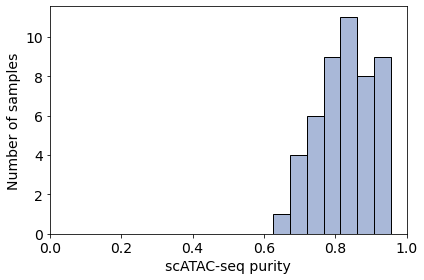

In [231]:
purity_to_plot = purity_table[purity_table["DiseaseState"]=="Polyp"]

print(np.mean(purity_to_plot["epithelial"]))
print(np.std(purity_to_plot["epithelial"]))

sns.histplot(purity_to_plot["epithelial"], binwidth=0.05, color=set2_colors[2])
plt.xlim(0,1)
plt.xlabel("scATAC-seq purity", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir+"polyp_purities.pdf")
plt.show()

0.7241316332455019
0.13498528908703872


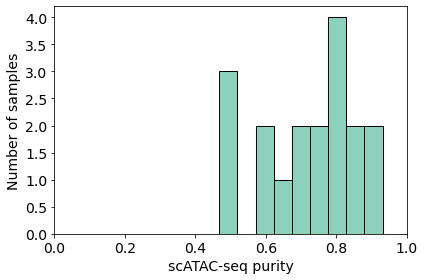

In [233]:
purity_to_plot = purity_table[purity_table["DiseaseState"]=="Unaffected"]

print(np.mean(purity_to_plot["epithelial"]))
print(np.std(purity_to_plot["epithelial"]))

sns.histplot(purity_to_plot["epithelial"], binwidth=0.05, color=set2_colors[0])
plt.xlim(0,1)
plt.xlabel("scATAC-seq purity", fontsize=14)
plt.ylabel("Number of samples", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir+"mucosa_purities.pdf")
plt.show()

In [5]:
def expected_mutant_copies(t_var_freq, total_copies, purity):
    '''
    From FACETS-SUITE (https://github.com/mskcc/facets-suite/tree/master), translated from R from ccf-annotate-maf.R.
    '''
    if np.isnan(total_copies) or total_copies == 0:
        return np.nan
    else:
        mu = t_var_freq * (1 / purity) * (purity * total_copies + (1 - purity) * 2)
        if mu < 1:
            return 1
        else:
            return round(abs(mu))

def estimate_ccf_purity(total_copies, t_alt_count, t_depth):
    '''
    Estimates posterior probability of ppVAF values given sequencing data at a single mutation locus across a mesh sweeping across sample purity values from 0.01 to 1.
    params:
    total_copies: int total copy number at mutation locus
    t_alt_count: int number of mutant reads at locus
    t_depth: int total number of reads at locus
    
    returns:
    100 x 1000 element numpy matrix of unnormalized ppVAF posterior probabilties at the mutation locus, where rows are sample purities from 0.01 to 1 and columns are ppVAF values from 0.001 to 1 (both evenly spaced)
    
    '''
    ccfs = np.linspace(0.001, 1, 1000).reshape(1, -1)
    purities = np.linspace(0.01, 1, 100)
    
    mutant_copies = np.array([expected_mutant_copies(t_alt_count/t_depth, total_copies, purity) for purity in purities]).reshape(-1, 1)
    
    purities = purities.reshape(-1, 1)
    
    expected_vafs = purities * mutant_copies * ccfs / (2 * (1 - purities) + purities * total_copies)
    return(binom.pmf(t_alt_count, t_depth, expected_vafs))

#FUNCTIONS

def purity_dist_normalize(prob_mat, maf, purity_dict):
    all_stages = list(set(maf["Stage"]))
    for stage in all_stages:
        if stage not in purity_dict:
            raise AssertionError("invalid stage")
        has_stage = np.nonzero((maf["Stage"] == stage).tolist())[0]
        prob_mat[:, :, has_stage] = np.multiply(prob_mat[:, :, has_stage], purity_dict[stage].reshape((-1, 1, 1)))
    prob_mat = np.divide(prob_mat, np.sum(prob_mat, axis=(0,1)).reshape(1, 1, -1))
    return prob_mat

def get_ccfs_clonality_many(probs):
    num_ccf_grid = np.shape(probs)[0]
    
    ccfs = np.argmax(probs, axis=0)
    ccf_half_max = probs > (np.max(probs, axis=0).reshape((1, -1)) / 2)
    ccf_half_max = np.where(ccf_half_max==0, np.nan, np.arange(num_ccf_grid).reshape(-1,1))
    
    ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
    ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)

    ccf_lower = ccf_lower / num_ccf_grid
    ccf_upper = ccf_upper / num_ccf_grid
    
    ccfs = ccfs/num_ccf_grid
    
    clonality = np.array(["SUBCLONAL-"] * np.shape(probs)[1])
    clonal_condition = np.logical_and(ccfs >= .9, np.sum(probs[850:, :], axis=0)>=0.75)
    clonality = np.where(clonal_condition, "CLONAL+", clonality)
    clonal_condition = np.logical_and(ccf_lower < .5, np.sum(probs[:500, :], axis=0)>=0.75)
    clonality = np.where(clonal_condition, "SUBCLONAL+", clonality)
    clonal_condition = np.logical_and(ccfs >= .9, np.logical_or(np.sum(probs[850:, :], axis=0)>=0.5, ccf_lower>=0.5))
    clonality = np.where(clonal_condition, "CLONAL-", clonality)
    return (ccfs, clonality, ccf_lower, ccf_upper)

def get_CCF_MAP(prob_mat, maf, ccf_col="purity_ccf", clonal_col="purity_clonal", bounds_prefix="purity"):
    #adds new columns to maf df with best ccf estimate marginalized over purity distribution
    marginalized = np.sum(prob_mat, axis=0) * prob_mat.shape[1]
    CCFs, clonality, lower, upper = get_ccfs_clonality_many(marginalized)
    maf[ccf_col] = CCFs
    maf[clonal_col] = clonality
    maf[bounds_prefix+"_lower"] = lower
    maf[bounds_prefix+"_upper"] = upper
    return marginalized

def expected_count_clonal(prob_mat, maf, clonal_thresholds=[0.95], filter_maf=None):
    num_ccf_grid = np.shape(prob_mat)[1]
    
    if filter_maf is not None:
        filtered_mat = prob_mat[:, :, filter_maf]
        CI_clonal = [np.nansum(maf.iloc[filter_maf]["purity_upper"]==1)]
    else:
        filtered_mat = prob_mat
        CI_clonal = [np.nansum(maf["purity_upper"]==1)]
    
    
    df_return = pd.DataFrame({"CI_clonal":CI_clonal})
    
    
    for clonal_threshold in clonal_thresholds:
        idx_threshold = int(clonal_threshold*num_ccf_grid)
        probs_clonal = np.sum(prob_mat[:, idx_threshold:, :], axis=(0, 1))
        maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
        df_return["exp_clonal_"+str(clonal_threshold)] = np.nansum(filtered_mat[:, idx_threshold:, :])
            
    return df_return

def add_ccfs_count_clonal(prob_mat, maf, purity_dict, clonal_thresholds):
    maf_save = None
    clonal = None
    all_marg = np.zeros((np.shape(prob_mat)[2], np.shape(prob_mat)[1]))
    start_idx = 0
    for sample in list(set(maf["Tumor_Sample_Barcode"])):
        is_sample = np.nonzero((maf["Tumor_Sample_Barcode"] == sample).tolist())[0]
        new_maf = maf.iloc[is_sample]
        new_mat = prob_mat[:, :, is_sample]
        n_muts = len(new_maf)
        new_mat = purity_dist_normalize(new_mat, new_maf, purity_dict)
        marg = get_CCF_MAP(new_mat, new_maf)
        all_marg[start_idx:start_idx+n_muts,:] = np.transpose(marg)
        start_idx += n_muts
        
        filter_maf = np.logical_and(np.isin(new_maf["Reference_Allele"], ["A", "T", "C", "G"]), np.isin(new_maf["Tumor_Seq_Allele2"], ["A", "T", "C", "G"]))
        filter_maf = np.logical_and(filter_maf, new_maf["t_depth"] >= 10)
        filter_maf = np.logical_and(filter_maf, new_maf["t_alt_count"] >= 2)
        filter_maf = np.logical_and(filter_maf, new_maf["vaf"] >= 0.01)
        clonal_add = expected_count_clonal(new_mat, new_maf, clonal_thresholds=clonal_thresholds, filter_maf=np.nonzero((filter_maf).tolist())[0])
        clonal_add["sample"] = sample

        if clonal is None:
            clonal = clonal_add
        else:
            clonal = pd.concat([clonal, clonal_add])
        if maf_save is None:
            maf_save = new_maf
        else:
            maf_save = pd.concat([maf_save, new_maf], ignore_index=True)
    return maf_save, clonal, all_marg

def filter_maf_depth(maf, min_total=0, min_alt=0, min_vaf=0):
    to_return = maf[maf["t_depth"] >= min_total]
    to_return = to_return[to_return["t_alt_count"] >= min_alt]
    return to_return[to_return["vaf"] >= min_vaf]

def sample_to_patient(sample):
    if sample[0] == "A":
        patient = sample[:4]
    else:
        patient = sample[:1] + "001"
    return patient

def get_true_clonal(estimated, n_muts, z_clonal, z_subclonal):
    return (estimated - n_muts * z_subclonal)/(z_clonal-z_subclonal)

In [6]:
PKU_ccfmat = np.zeros((100,1000,len(PKU_maf)))

for i in range(len(PKU_maf)):
    row = PKU_maf.iloc[i]
    total_cn = row["tcn"]
    if np.isnan(total_cn) or total_cn == 0:
        total_cn = 2
    PKU_ccfmat[:, :, i] = estimate_ccf_purity(total_cn, row["t_alt_count"], row["t_depth"])

thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]
PKU_maf, PKU_clonal, marg = add_ccfs_count_clonal(PKU_ccfmat, PKU_maf, purity_dict, thresholds)

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [7]:
BCI_ccfmat = np.zeros((100,1000,len(BCI_maf)))

for i in range(len(BCI_maf)):
    row = BCI_maf.iloc[i]
    total_cn = row["tcn"]
    if np.isnan(total_cn) or total_cn == 0:
        total_cn = 2
    BCI_ccfmat[:, :, i] = estimate_ccf_purity(total_cn, row["t_alt_count"], row["t_depth"])
    
BCI_maf, BCI_clonal, marg = add_ccfs_count_clonal(BCI_ccfmat, BCI_maf, purity_dict, thresholds)

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf["clonal_cont_"+str(clonal_threshold)] = probs_clonal
/tmp/ipykernel_214754/3625236795.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[clonal_col] = clonality
/tmp/ipykernel_214754/3625236795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

/tmp/ipykernel_214754/3625236795.py:55: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:56: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)
/tmp/ipykernel_214754/3625236795.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maf[ccf_col] = CCFs
/tmp/ipykernel_214754/3625236795.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [8]:
BCI_sample_to_stage = dict(zip(BCI_maf["Tumor_Sample_Barcode"], BCI_maf["Stage"]))
BCI_clonal["stage"] = [BCI_sample_to_stage[x] for x in BCI_clonal["sample"]]

PKU_sample_to_stage = dict(zip(PKU_maf["Tumor_Sample_Barcode"], PKU_maf["Stage"]))
PKU_clonal["stage"] = [PKU_sample_to_stage[x] for x in PKU_clonal["sample"]]

PKU_sample_to_patient = dict(zip(PKU_maf["Tumor_Sample_Barcode"], PKU_maf["Patient"]))
PKU_clonal["patient"] = [PKU_sample_to_patient[x] for x in PKU_clonal["sample"]]

BCI_sample_to_patient = dict(zip(BCI_maf["Tumor_Sample_Barcode"], BCI_maf["Patient"]))
BCI_clonal["patient"] = [BCI_sample_to_patient[x] for x in BCI_clonal["sample"]]

In [9]:
PKU_clonal["lesion"] = ["_".join(x.split("_")[:2]) for x in PKU_clonal["sample"]]
PKU_sample_to_lesion = dict(zip(PKU_clonal["sample"], PKU_clonal["lesion"]))
PKU_maf["lesion"] = [PKU_sample_to_lesion[x] for x in PKU_maf["Tumor_Sample_Barcode"]]
PKU_clonal.sort_values("lesion", inplace=True)

In [10]:
PKU_snvs = PKU_maf[np.logical_and(np.isin(PKU_maf["Reference_Allele"], ["A", "T", "C", "G"]), np.isin(PKU_maf["Tumor_Seq_Allele2"], ["A", "T", "C", "G"]))]

mut_counts = PKU_snvs.value_counts("Tumor_Sample_Barcode")
sample_to_total = dict(zip(mut_counts.index, mut_counts.values))

PKU_clonal["total_counts"] = [sample_to_total[x] for x in PKU_clonal["sample"]]

In [11]:
summary_stats = pd.read_csv("../../data/clonal_estimator_sim_results/WGS_summary_stats.csv", index_col=0)

In [12]:
for threshold in thresholds:
    PKU_clonal["new_clonal_"+str(threshold)] = get_true_clonal(PKU_clonal["exp_clonal_"+str(threshold)], PKU_clonal["total_counts"], summary_stats.loc[threshold]["clonal_mean"], summary_stats.loc[threshold]["subclonal_mean"])
    

In [13]:
to_exclude = ["CRC1", "CRC2", "MAP1"]

WGS_cutoff = 27 + 36
WES_cutoff = WGS_cutoff * 0.01

def number_shared_MRS(lesion_maf):
    shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
    return np.sum(shared_muts==len(set(lesion_maf["Tumor_Sample_Barcode"])))

multiregion_lesions = pd.value_counts(PKU_clonal["lesion"])
multiregion_lesions = multiregion_lesions[multiregion_lesions > 1]
multiregion_lesions = multiregion_lesions[~np.isin([x.split("_")[0] for x in multiregion_lesions.index], to_exclude)]
shared_counts_MRS = []
for lesion in multiregion_lesions.index:
    only_lesion = PKU_snvs[PKU_snvs["lesion"]==lesion]
    shared_counts_MRS.append(number_shared_MRS(only_lesion))

/tmp/ipykernel_214754/361562629.py:10: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  multiregion_lesions = pd.value_counts(PKU_clonal["lesion"])
/tmp/ipykernel_214754/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
/tmp/ipykernel_214754/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
/tmp/ipykernel_214754/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
/tmp/ipykernel_214754/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and 

/tmp/ipykernel_20080/4105399581.py:11: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=multiregion_lesions.index, y=np.log10(shared_counts_MRS), marker="x", s=100, color="k", zorder=100,linewidths=3)


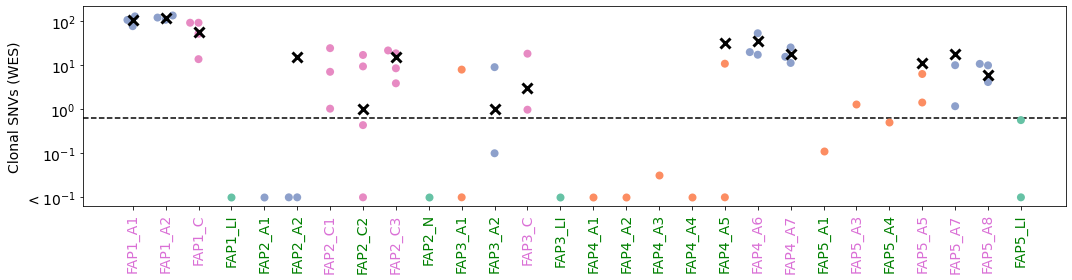

In [69]:
# EXTENDED DATA FIGURE 8a

to_plot = PKU_clonal[~np.isin(PKU_clonal["patient"], to_exclude)]

to_count = PKU_clonal[~np.isin(PKU_clonal["patient"], to_exclude)]
counted = to_count.groupby("lesion").min()
counted["is_poly"] = counted["new_clonal_0.95"] < WES_cutoff

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.swarmplot(x=to_plot["lesion"], y=np.log10(np.maximum(0.01, to_plot["new_clonal_0.95"])), hue=to_plot["stage"], hue_order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", legend=None, ax=ax, size=8)
sns.scatterplot(x=multiregion_lesions.index, y=np.log10(shared_counts_MRS), marker="x", s=100, color="k", zorder=100,linewidths=3)
ax.axhline(y=np.log10(WES_cutoff), color="k", linestyle="dashed")
plt.xticks(rotation=90, fontsize=14)

for xtick in ax.get_xticklabels():
    if counted.loc[xtick._text]["is_poly"]:
        xtick.set_color(poly_color)
    else:
        xtick.set_color(mono_color)

plt.yticks(ticks = [-2, -1, 0, 1, 2], labels = ["$< 10^{-1}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=14)
plt.ylabel("Clonal SNVs (WES)", fontsize=14)
#plt.yscale("log")
plt.xlabel("")
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8a_FAP_Li_clonalmuts.pdf")
plt.show()

In [82]:
BCI_snvs = BCI_maf[np.logical_and(np.isin(BCI_maf["Reference_Allele"], ["A", "T", "C", "G"]), np.isin(BCI_maf["Tumor_Seq_Allele2"], ["A", "T", "C", "G"]))]

mut_counts =BCI_snvs.value_counts("Tumor_Sample_Barcode")
sample_to_total = dict(zip(mut_counts.index, mut_counts.values))

BCI_clonal["total_counts"] = [sample_to_total[x] for x in BCI_clonal["sample"]]

for threshold in thresholds:
    BCI_clonal["new_clonal_"+str(threshold)] = get_true_clonal(BCI_clonal["exp_clonal_"+str(threshold)], BCI_clonal["total_counts"], summary_stats.loc[threshold]["clonal_mean"], summary_stats.loc[threshold]["subclonal_mean"])


In [71]:
multiregion_lesions = pd.value_counts(BCI_clonal["patient"])
multiregion_lesions = multiregion_lesions[multiregion_lesions > 1]
#multiregion_lesions = multiregion_lesions[~np.isin([x.split("_")[0] for x in multiregion_lesions.index], to_exclude)]
shared_counts_MRS = []
for lesion in multiregion_lesions.index:
    only_lesion = BCI_snvs[BCI_snvs["Patient"]==lesion]
    shared_counts_MRS.append(number_shared_MRS(only_lesion))
    
BCI_clonal.sort_values("patient", inplace=True)

to_count = BCI_clonal

counted = to_count.groupby("patient").min()
counted["is_poly"] = counted["new_clonal_0.95"] < WES_cutoff

/tmp/ipykernel_20080/139903344.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  multiregion_lesions = pd.value_counts(BCI_clonal["patient"])
/tmp/ipykernel_20080/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
/tmp/ipykernel_20080/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
/tmp/ipykernel_20080/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
/tmp/ipykernel_20080/361562629.py:7: FutureWarning: pandas.value_counts is deprecated and will 

/home/users/dve/.local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/users/dve/.local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/users/dve/.local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/users/dve/.local/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


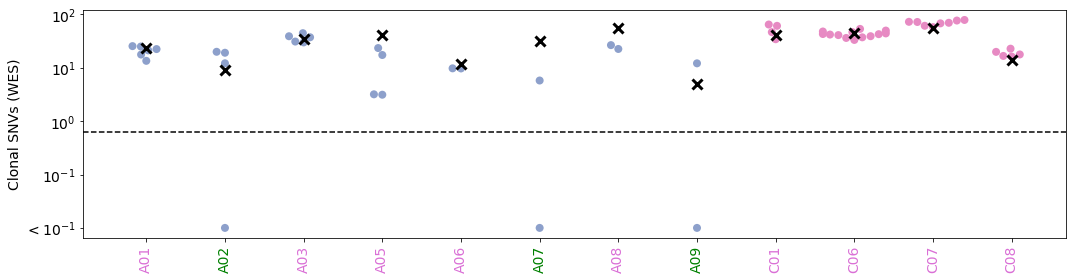

In [74]:
# EXTENDED DATA FIGURE 8b

WGS_cutoff = 27 + 36
WES_cutoff = WGS_cutoff * 0.01

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.swarmplot(x=BCI_clonal["patient"], y=np.log10(np.maximum(1e-2,BCI_clonal["new_clonal_0.95"])), hue=BCI_clonal["stage"], hue_order=["none", "alsonone", "Adenoma", "Carcinoma"], palette="Set2", legend=None, ax=ax, size=8)
sns.scatterplot(x=multiregion_lesions.index, y=np.log10(shared_counts_MRS), marker="x", s=100, color="k", zorder=100,linewidths=3)
ax.axhline(y=np.log10(WES_cutoff), color="k", linestyle="dashed")
plt.xticks(rotation=90, fontsize=14)

for xtick in ax.get_xticklabels():
    if counted.loc[xtick._text]["is_poly"]:
        xtick.set_color(poly_color)
    else:
        xtick.set_color(mono_color)

plt.yticks(ticks = [-2, -1, 0, 1, 2], labels = ["$< 10^{-1}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"], fontsize=14)
plt.ylabel("Clonal SNVs (WES)", fontsize=14)
#plt.yscale("log")
plt.xlabel("")
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8b_sporadic_Cross_clonalmuts.pdf")
plt.show()

/tmp/ipykernel_20080/4232297857.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counted["stage"], y=counted["is_poly"], order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", errorbar=compute_errorbars)


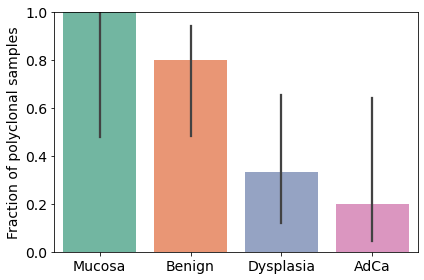

/tmp/ipykernel_20080/4232297857.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counted["stage"], y=counted["is_poly"], hue_order=["Adenoma", "Carcinoma"], palette=set2_colors[2:], errorbar=compute_errorbars)


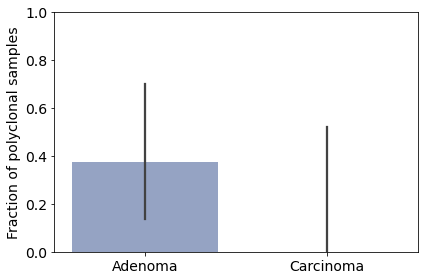

In [18]:
# EXTENDED DATA FIGURE 8c-d

def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data.astype("boolean")), np.sum(~binom_data.astype("boolean")))

to_count = PKU_clonal[~np.isin(PKU_clonal["patient"], to_exclude)]
counted = to_count.groupby("lesion").min()
counted["is_poly"] = counted["new_clonal_0.95"] < WES_cutoff

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
#sns.barplot(x=frac_poly.index, y=frac_poly, order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)
sns.barplot(x=counted["stage"], y=counted["is_poly"], order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", errorbar=compute_errorbars)
plt.ylabel("Fraction of polyclonal samples", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8c_FAP_Li_polyclonal.pdf")
plt.show()

to_count = BCI_clonal
counted = to_count.groupby("patient").min()
counted["is_poly"] = counted["new_clonal_0.95"] < WES_cutoff

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
#sns.barplot(x=frac_poly.index, y=frac_poly, order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)
sns.barplot(x=counted["stage"], y=counted["is_poly"], hue_order=["Adenoma", "Carcinoma"], palette=set2_colors[2:], errorbar=compute_errorbars)
plt.ylabel("Fraction of polyclonal samples", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8d_sporadic_Cross_polyclonal.pdf")
plt.show()